--- Weibull Analysis Started ---

Step 1: Preparing Data...
ML_final used for normalization: 33.00 mg
Number of data points for Weibull plot: 14

Step 2: Transforming Data and Estimating Parameters...
Estimated Beta (shape parameter): 1.887
Estimated Eta (scale parameter/characteristic time): 11.267 h
R-squared for the fit: 0.9993

Step 3: Calculating Key Erosion Parameters...
Time to reach F(t)=0.01% (proxy for practical incubation): 0.086 h
Calculated t_MER: 7.553 h
Calculated t_in (Nominal Incubation Time): 2.443 h
Calculated t_threshold (for F(t)=1.0%): 0.984 h

--- Weibull Analysis Finished ---


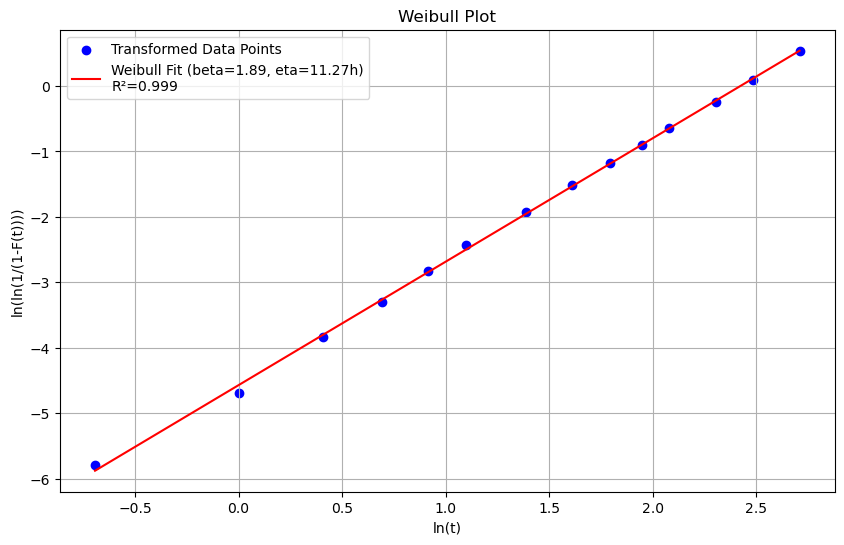

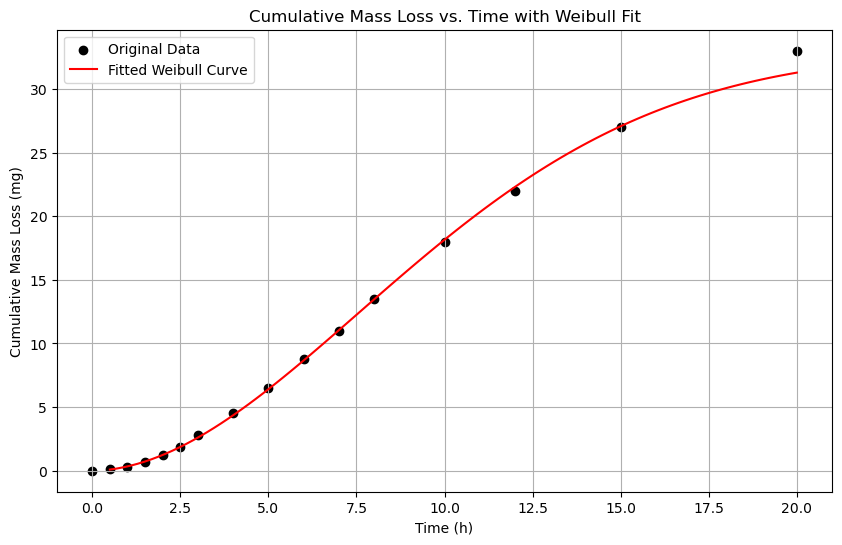

In [2]:
import numpy as np
from scipy.stats import linregress

# --- Step 1: Data Preparation ---
def prepare_data(times, cumulative_mass_loss):
    """
    Converts cumulative mass loss to cumulative fraction failed F(t).

    Args:
        times (np.array): Array of time points.
        cumulative_mass_loss (np.array): Array of cumulative mass loss values.

    Returns:
        tuple: (filtered_times, F_t_values, ml_final)
               filtered_times: Times corresponding to valid F(t) values.
               F_t_values: Cumulative fraction failed.
               ml_final: The final (maximum) mass loss used for normalization.
    """
    if len(times) != len(cumulative_mass_loss):
        raise ValueError("Times and cumulative_mass_loss arrays must have the same length.")
    if not len(times):
        raise ValueError("Input arrays cannot be empty.")

    # Use the maximum observed mass loss as ML_final
    ml_final = np.max(cumulative_mass_loss)
    if ml_final == 0:
        print("Warning: ML_final is 0. F(t) cannot be calculated properly. Returning empty arrays.")
        return np.array([]), np.array([]), 0

    # Calculate F(t) = ML_i / ML_final
    F_t_values = cumulative_mass_loss / ml_final

    # Filter out data points where F(t) is 0 or 1, or time is 0, as these
    # cannot be used in the logarithmic transformations for Weibull plotting.
    # We need 0 < F(t) < 1 and t > 0.
    valid_indices = (F_t_values > 0) & (F_t_values < 1) & (times > 0)
    
    filtered_times = times[valid_indices]
    filtered_F_t = F_t_values[valid_indices]

    if len(filtered_times) == 0:
        print("Warning: No valid data points after filtering for 0 < F(t) < 1 and t > 0.")
        
    return filtered_times, filtered_F_t, ml_final

# --- Step 2: Weibull Plotting and Parameter Estimation ---
def transform_for_weibull_plot(times, F_t_values):
    """
    Transforms data for Weibull plotting.
    X = ln(t)
    Y = ln(ln(1 / (1 - F(t))))

    Args:
        times (np.array): Array of time points (already filtered, t > 0).
        F_t_values (np.array): Array of F(t) values (already filtered, 0 < F(t) < 1).

    Returns:
        tuple: (X_weibull, Y_weibull)
    """
    if not len(times): # Should be caught by prepare_data, but good to have a check
        return np.array([]), np.array([])

    X_weibull = np.log(times)
    Y_weibull = np.log(np.log(1 / (1 - F_t_values)))
    return X_weibull, Y_weibull

def estimate_weibull_parameters(X_weibull, Y_weibull):
    """
    Estimates Weibull parameters eta and beta using linear regression.
    Y = beta * X - beta * ln(eta)
    Slope m = beta
    Intercept c = -beta * ln(eta) => eta = exp(-c / beta)

    Args:
        X_weibull (np.array): Transformed time data (ln(t)).
        Y_weibull (np.array): Transformed F(t) data (ln(ln(1/(1-F(t))))).

    Returns:
        tuple: (beta, eta, r_squared) or (None, None, None) if regression fails.
               beta: Shape parameter.
               eta: Scale parameter (characteristic time).
               r_squared: Coefficient of determination for the fit.
    """
    if len(X_weibull) < 2 or len(Y_weibull) < 2:
        print("Warning: Not enough data points for linear regression.")
        return None, None, None

    slope, intercept, r_value, p_value, std_err = linregress(X_weibull, Y_weibull)

    beta = slope
    if beta == 0: # Avoid division by zero
        print("Warning: Estimated beta (slope) is 0. Cannot calculate eta.")
        return beta, None, r_value**2
        
    eta = np.exp(-intercept / beta)
    r_squared = r_value**2
    
    return beta, eta, r_squared

# --- Step 3: Calculating Key Erosion Parameters ---
def calculate_t_mer(eta, beta):
    """
    Calculates Time at Maximum Erosion Rate (t_MER).
    t_MER = eta * ((beta - 1) / beta)^(1 / beta)
    Valid for beta > 1.

    Args:
        eta (float): Scale parameter.
        beta (float): Shape parameter.

    Returns:
        float: t_MER, or None if beta <= 1 or parameters are invalid.
    """
    if eta is None or beta is None:
        return None
    if beta <= 1:
        print(f"Warning: beta ({beta:.2f}) <= 1. t_MER is not well-defined or occurs at t=0.")
        return 0 # Or None, depending on desired interpretation
    
    try:
        t_mer = eta * ((beta - 1) / beta)**(1 / beta)
    except (ZeroDivisionError, TypeError, ValueError) as e:
        print(f"Error calculating t_MER: {e}")
        return None
    return t_mer

def calculate_t_in(eta, beta, t_mer):
    """
    Calculates Nominal Incubation Time (t_in).
    k = exp(-(t_MER / eta)^beta)
    t_in = t_MER - (1 - k) / ((beta / eta^beta) * t_MER^(beta - 1) * k)

    Args:
        eta (float): Scale parameter.
        beta (float): Shape parameter.
        t_mer (float): Time at Maximum Erosion Rate.

    Returns:
        float: t_in, or None if inputs are invalid.
    """
    if eta is None or beta is None or t_mer is None or t_mer < 0: # t_mer can be 0 if beta <=1
        return None
    if eta == 0: # Avoid division by zero
        print("Warning: eta is 0 in calculate_t_in.")
        return None

    try:
        # Handle t_mer = 0 case (e.g., when beta is close to 1)
        if t_mer == 0:
             # If t_MER is 0, the tangent starts at the origin, so t_in would also be 0.
             # This aligns with MER occurring at t=0 for beta=1.
            return 0

        k = np.exp(-(t_mer / eta)**beta)
        
        if k == 0: # Avoid division by zero in the denominator
            print("Warning: k is 0 in t_in calculation. Denominator would be zero.")
            # This can happen if (t_mer/eta)^beta is very large.
            # If k=0, it implies F(t_MER) is 1. The tangent might be vertical or ill-defined.
            # Or, if MER is very high, delta_t could be very small.
            # For practical purposes, if k is extremely small, 1-k is approx 1.
            # If the MER term (denominator) is also very large, t_in might approach t_MER.
            return None # Or handle as a special case based on erosion curve shape.


        mer_at_t_mer = (beta / (eta**beta)) * (t_mer**(beta - 1)) * k
        if mer_at_t_mer == 0:
            print("Warning: Calculated MER at t_MER is 0. Cannot calculate t_in (division by zero).")
            return None

        delta_t = (1 - k) / mer_at_t_mer
        t_in = t_mer - delta_t
    except (ZeroDivisionError, OverflowError, ValueError) as e:
        print(f"Error calculating t_in: {e}")
        return None
    return t_in

def calculate_t_threshold(eta, beta, F_threshold):
    """
    Calculates Erosion Threshold Time (t_1 or similar) for a given F_threshold.
    t_threshold = eta * (ln(1 / (1 - F_threshold)))^(1 / beta)

    Args:
        eta (float): Scale parameter.
        beta (float): Shape parameter.
        F_threshold (float): Cumulative fraction failed defining the threshold (e.g., 0.01 for 1%).
                             Must be 0 < F_threshold < 1.

    Returns:
        float: t_threshold, or None if inputs are invalid.
    """
    if eta is None or beta is None:
        return None
    if not (0 < F_threshold < 1):
        raise ValueError("F_threshold must be between 0 and 1 (exclusive).")
    if beta == 0: # Avoid division by zero
        print("Warning: beta is 0 in calculate_t_threshold.")
        return None

    try:
        # ln(1 / (1 - F_threshold)) is -ln(1 - F_threshold)
        log_term = np.log(1 / (1 - F_threshold))
        if log_term < 0 and (1/beta) % 1 != 0: # Avoid complex numbers for non-integer roots of negative numbers
            print("Warning: log_term is negative, and 1/beta is not an integer. Result might be complex or undefined.")
            return None
        t_thresh = eta * (log_term**(1 / beta))
    except (ZeroDivisionError, ValueError, OverflowError) as e:
        print(f"Error calculating t_threshold: {e}")
        return None
    return t_thresh

# --- Main Example Usage ---
if __name__ == "__main__":
    # Example Data (replace with your actual experimental data)
    # times_h: time in hours
    # mass_loss_mg: cumulative mass loss in mg
    times_h = np.array([0, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8, 10, 12, 15, 20])
    mass_loss_mg = np.array([0, 0.1, 0.3, 0.7, 1.2, 1.9, 2.8, 4.5, 6.5, 8.8, 11.0, 13.5, 18.0, 22.0, 27.0, 33.0])
    
    # If you have MDE data and want to use a specific MDE for threshold (e.g., 1 um MDE)
    # You would first convert that MDE_threshold to ML_threshold using density and area,
    # then ML_threshold to F_threshold.
    # For this example, let's define a threshold as 1% of final mass loss.
    F_threshold_for_t1 = 0.01 # Corresponds to 1% of ML_final

    print("--- Weibull Analysis Started ---")

    # Step 1: Prepare Data
    print("\nStep 1: Preparing Data...")
    filtered_times, F_t, ml_final_actual = prepare_data(times_h, mass_loss_mg)
    if ml_final_actual == 0 or len(filtered_times) == 0:
        print("Exiting due to data preparation issues.")
    else:
        print(f"ML_final used for normalization: {ml_final_actual:.2f} mg")
        print(f"Number of data points for Weibull plot: {len(filtered_times)}")

        # Step 2: Transform Data and Estimate Weibull Parameters
        print("\nStep 2: Transforming Data and Estimating Parameters...")
        X_wb, Y_wb = transform_for_weibull_plot(filtered_times, F_t)
        
        # For bi-modal, you would visually inspect the plot of Y_wb vs X_wb
        # and split X_wb, Y_wb into segments for separate regressions.
        # This example assumes a single mode for simplicity.
        beta_est, eta_est, r2_est = estimate_weibull_parameters(X_wb, Y_wb)

        if beta_est is not None and eta_est is not None:
            print(f"Estimated Beta (shape parameter): {beta_est:.3f}")
            print(f"Estimated Eta (scale parameter/characteristic time): {eta_est:.3f} h")
            print(f"R-squared for the fit: {r2_est:.4f}")

            # Step 3: Calculate Key Erosion Parameters
            print("\nStep 3: Calculating Key Erosion Parameters...")
            
            # t_i (Incubation Time)
            # As per theory, Weibull model predicts t_i -> 0 as F(t) -> 0.
            # The practical incubation time is when mass loss is below detection.
            # We can calculate time to a very small F(t), e.g., F(t) = 0.001
            F_very_small = 0.0001 
            t_practical_incubation = calculate_t_threshold(eta_est, beta_est, F_very_small)
            if t_practical_incubation is not None:
                 print(f"Time to reach F(t)={F_very_small*100}% (proxy for practical incubation): {t_practical_incubation:.3f} h")


            # t_MER (Time at Maximum Erosion Rate)
            t_mer_calc = calculate_t_mer(eta_est, beta_est)
            if t_mer_calc is not None:
                print(f"Calculated t_MER: {t_mer_calc:.3f} h")

                # t_in (Nominal Incubation Time)
                t_in_calc = calculate_t_in(eta_est, beta_est, t_mer_calc)
                if t_in_calc is not None:
                    print(f"Calculated t_in (Nominal Incubation Time): {t_in_calc:.3f} h")
                else:
                    print("Could not calculate t_in.")
            else:
                print("Could not calculate t_MER (and thus t_in).")

            # t_1 (Erosion Threshold Time for F_threshold_for_t1)
            t1_calc = calculate_t_threshold(eta_est, beta_est, F_threshold_for_t1)
            if t1_calc is not None:
                print(f"Calculated t_threshold (for F(t)={F_threshold_for_t1*100}%): {t1_calc:.3f} h")
            else:
                print(f"Could not calculate t_threshold for F(t)={F_threshold_for_t1*100}%.")

        else:
            print("Weibull parameter estimation failed.")
            
    print("\n--- Weibull Analysis Finished ---")

    # For visualization (optional, requires matplotlib)
    import matplotlib.pyplot as plt
    if beta_est is not None and eta_est is not None and len(X_wb)>0:
        plt.figure(figsize=(10, 6))
        plt.scatter(X_wb, Y_wb, label='Transformed Data Points', color='blue')
        Y_fit = beta_est * X_wb - beta_est * np.log(eta_est)
        plt.plot(X_wb, Y_fit, label=f'Weibull Fit (beta={beta_est:.2f}, eta={eta_est:.2f}h)\nR²={r2_est:.3f}', color='red')
        plt.xlabel('ln(t)')
        plt.ylabel('ln(ln(1/(1-F(t))))')
        plt.title('Weibull Plot')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.scatter(times_h, mass_loss_mg, label='Original Data', color='black', marker='o')
        # Plot the fitted Weibull curve on original scale
        t_plot = np.linspace(min(filtered_times) if len(filtered_times)>0 else 0.1, max(times_h) if len(times_h)>0 else 1, 100)
        F_t_fitted = 1 - np.exp(-(t_plot / eta_est)**beta_est)
        ML_fitted = F_t_fitted * ml_final_actual
        plt.plot(t_plot, ML_fitted, label='Fitted Weibull Curve', color='red')
        plt.xlabel('Time (h)')
        plt.ylabel('Cumulative Mass Loss (mg)')
        plt.title('Cumulative Mass Loss vs. Time with Weibull Fit')
        plt.legend()
        plt.grid(True)
        plt.show()

